# **Food101 Computer Vision**

This project explores the use of **mixed-precision training** technique to train a feature extraction model on the Food101 dataset using TensorFlow: https://www.tensorflow.org/datasets/catalog/food101


The goal of this project is to surpass the benchmarks set by DeepFood, a seminal 2016 paper renowned for its Convolutional Neural Network's remarkable top-1 accuracy of 77.4%.

**Original paper**: https://arxiv.org/abs/1606.05675

In my project I conducted two experiments to fine-tune the feature extraction baseline model of EfficientNet:

* **Experiment 1** involved training the model for three more epochs
* **Experiment 2** incorporated learning rate tuning using the ReduceLROnPlateau callback and early stopping.

I concluded my project by summarizing the findings and providing a final conclusion.

I also compared the training results of each experiment using TensorBoard, which offered valuable visual insights into the model's performance.

In [ ]:
import tensorflow as tf

While using mixed-precision training it is necessary to use a **GPU with compute capability of 7.0 or higher**. Only in those cases the greatest performance benefit from mixed precision can be seen, because those GPUs have special hardware units, called Tensor Cores, to accelerate float16 matrix multiplications and convolutions. In case of Google Colab - Tesla T4 seems to be the most appropriate choice.


Check the **GPU computability**:
https://developer.nvidia.com/cuda-gpus


In [ ]:
!nvidia-smi

Sat Jun 24 06:16:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Preprocessing**

I will download the data and explore it using **TensorFlow Datasets** TFDS.

I will also create a custom function to convert the image shape and type, which then I will map on the entire dataset using a **mapping function**.

Finally, to optimize the dataset loading and performance, I will apply **parallelization**, **prefetching**, and **batching techniques**.

## Load the helper functions from Github repo

In [ ]:
!wget https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_eval.py

--2023-06-24 06:16:54--  https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2862 (2.8K) [text/plain]
Saving to: ‘useful_functions_eval.py’

useful_functions_ev 100%[===================>]   2.79K  --.-KB/s    in 0s      

2023-06-24 06:16:54 (42.2 MB/s) - ‘useful_functions_eval.py’ saved [2862/2862]



In [ ]:
!wget https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_img.py

--2023-06-24 06:16:54--  https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6012 (5.9K) [text/plain]
Saving to: ‘useful_functions_img.py’

useful_functions_im 100%[===================>]   5.87K  --.-KB/s    in 0s      

2023-06-24 06:16:54 (67.1 MB/s) - ‘useful_functions_img.py’ saved [6012/6012]



In [ ]:
!wget https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_train.py

--2023-06-24 06:16:54--  https://raw.githubusercontent.com/martgru/DeepLearning-projects/main/useful_functions_train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3481 (3.4K) [text/plain]
Saving to: ‘useful_functions_train.py’

useful_functions_tr 100%[===================>]   3.40K  --.-KB/s    in 0s      

2023-06-24 06:16:55 (52.7 MB/s) - ‘useful_functions_train.py’ saved [3481/3481]



In [ ]:
from useful_functions_eval import compare_histories, plot_loss_curves
from useful_functions_train import create_tensorboard_callback

## Load the data

I wll load the data with **TensorFlow Datasets TFDS**:
https://www.tensorflow.org/datasets

* as_supervised=True field -> the data gets returned as (data, labels) format
* with_info=True -> returns the meta_data as well

In [ ]:
import tensorflow_datasets as tfds

# check if food101 dataset is present in the list of all available datasets in TFDS
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# the data will be load directly in tensor format
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5FG56O/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5FG56O/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Get familiar with the dataset

Now I will explore some random images from the training dataset to get a better idea of what kind of dataset I will be dealing with.

I will also:

* find the **class_names** of all images
* get the shape and type of input data -> they should be **tensors**
* check the type of labels -> **one-hot encoded** or **label-encoded**


In [ ]:
# check what kind of info is stored in ds_info variable
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# get the class names
class_names = ds_info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

### Visualize sample data

because our data is **shuffled** -> train_data.take(1) will give us another sample as we refresh the cell

In [ ]:
# check the shape and type of data
train_sample = train_data.take(1)
train_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for img, label in train_sample:
  print(f'img shape={img.shape}\n')
  print(f'dtype={img.dtype}\n')
  print(f'target class={label}\n')
  print(f'class_name={class_names[label.numpy()]}')

img shape=(306, 512, 3)

dtype=<dtype: 'uint8'>

target class=29

class_name=cup_cakes


The kind of label I obtained : `target class=38` suggests me that I should use the **sparse_categoricalcrossentropy** as a loss function

In [ ]:
# check the img tensor
print(img)

tf.Tensor(
[[[199 100  15]
  [192  91   9]
  [202  95  23]
  ...
  [238 196 124]
  [237 195 123]
  [236 194 122]]

 [[210 110  25]
  [207 105  23]
  [194  86  13]
  ...
  [238 196 124]
  [236 194 122]
  [235 193 121]]

 [[205 103  18]
  [213 108  25]
  [196  86  11]
  ...
  [238 195 126]
  [237 194 125]
  [235 192 123]]

 ...

 [[ 95  28  11]
  [ 94  27  10]
  [ 84  17   0]
  ...
  [166  32   5]
  [166  32   3]
  [167  34   1]]

 [[ 87  24   7]
  [ 83  18   0]
  [ 87  20   1]
  ...
  [155  27   0]
  [164  39   9]
  [156  33   0]]

 [[ 83  21   6]
  [ 79  16   0]
  [ 85  19   0]
  ...
  [149  25   0]
  [157  36   5]
  [149  30   0]]], shape=(306, 512, 3), dtype=uint8)


In [ ]:
tf.reduce_min(img), tf.reduce_max(img)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

The data seems to be in `uint8` format and the entry-values of each tensor are between 0 and 255 which means the images are not scaled yet.
But in general the machine learning models are known to perform best on:
* **float32 dtype data** ( also float16 dtype in mixed-precision training technique)
* data splitted into **equal-sized batches**
* scaled/ **normalized data**

In [ ]:
print(label)
print(label.numpy())

tf.Tensor(29, shape=(), dtype=int64)
29


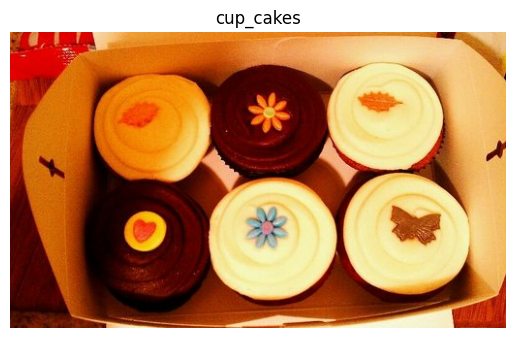

In [ ]:
# plot the img tensor
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(class_names[label.numpy()])
plt.axis("off");

### Plot some random samples

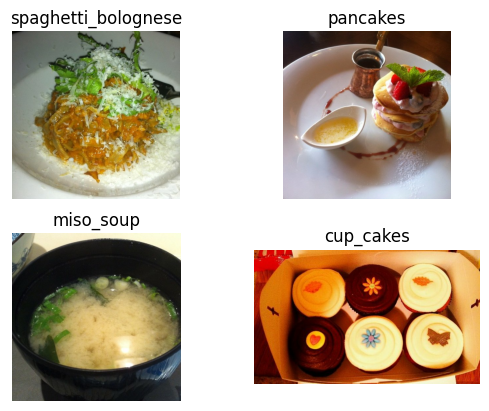

In [ ]:
for i in range(4):
  for random_img, random_img_label in train_data.take(1):
    plt.subplot(2,2,i+1)
    plt.imshow(random_img)
    plt.title(class_names[random_img_label.numpy()])
    plt.axis("off");


## Create some preprocessing functions for the data

I will use a custom function to convert the image shape and type before passing it to the model.

In [ ]:
def convert_img_shape_and_type(img, label, img_shape=224):
  """
  Converts img dtype from uint8 to float32 and reshapes img to a given shape.
  Returns a given img in format of (img, label) tuple
  """
  img = tf.image.resize(img, size=[img_shape,img_shape])
  return tf.cast(img, tf.float32),label


In [ ]:
preprocessed_img= convert_img_shape_and_type(img, label)
print(f"""Before = {img[:2]}
      shape = {img.shape}
      dtype = {img.dtype}\n""")
print(f'After = {preprocessed_img[:2]}')

Before = [[[199 100  15]
  [192  91   9]
  [202  95  23]
  ...
  [238 196 124]
  [237 195 123]
  [236 194 122]]

 [[210 110  25]
  [207 105  23]
  [194  86  13]
  ...
  [238 196 124]
  [236 194 122]
  [235 193 121]]]
      shape = (306, 512, 3)
      dtype = <dtype: 'uint8'>

After = (<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[196.98405   ,  96.515305  ,  13.443877  ],
        [185.15625   ,  75.776146  ,  10.615431  ],
        [176.09981   ,  62.711414  ,   9.320153  ],
        ...,
        [237.2455    , 192.6027    , 122.24549   ],
        [238.        , 196.        , 124.        ],
        [236.4598    , 194.4598    , 122.459785  ]],

       [[209.20886   , 106.47194   ,  23.047512  ],
        [168.58833   ,  56.285706  ,   0.8501243 ],
        [166.6894    ,  53.45121   ,   2.8341837 ],
        ...,
        [236.62468   , 192.2172    , 121.85998   ],
        [238.50987   , 195.96077   , 125.60809   ],
        [235.9958    , 193.4467    , 123.09402   ]],

     

## Batch the training dataset into smaller subsets

I will use the **batching technique** to make tensorflow load my data much faster.

By grouping multiple data samples into batches, the model can process them simultaneously, reducing the overhead of loading individual samples. This technique leverages the parallel processing capabilities of modern hardware, allowing TensorFlow to efficiently utilize system resources and expedite the data loading process.

https://www.tensorflow.org/guide/data


### Map a preprocessing function to a training data and parallelize it

**Parallelize the map transformation with setting the num_parallel_calls parameter**
https://www.tensorflow.org/guide/data_performance


> **num_parallel_calls** -> representing the number of batches to compute asynchronously in parallel. If not specified, batches will be computed sequentially. If the value tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available resources.

In [ ]:
# apply convert_img_shape_and_type function to all elements in train_data dataset = preprocess all images
train_data = train_data.map(map_func=convert_img_shape_and_type, num_parallel_calls=tf.data.AUTOTUNE)

Depending on the amount of the memory we have available, we may not be able to set the **buffer_size** to len(train_data). In our case : buffer_size=1000 means that we're going to shuffle a 1000 samples at a time.

Setting it to a **tf.data.AUTOTUNE** is like saying : "find out how many processes we're able to use and then use as many as you can at a time"

**prefetch** -> is like saying "when you're doing all the computing to find patterns in one batch of data on a GPU, get another batch ready to go as you're finding those patterns"

In [ ]:
# shuffle train data and turn it into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

### Map a preprocessing function to a test data and parallelize it

By parallelizing the operation, the preprocessing function can be applied to multiple samples simultaneously, taking advantage of multi-core processors and accelerating the process.

New dimension appeares (batch size) -> shape=(**None**, 224, 224, 3), dtype=tf.float32

In [ ]:
test_data = test_data.map(map_func=convert_img_shape_and_type, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create callbacks

In my experiments I will use several modeling callbacks, including **TensorBoard** and **ModelCheckpoint** to track and monitor the training process of my model.

* **TensorBoard callback** -> to save=log training results to visualize them later
* **ModelCheckpoint callback** -> to save the model's progress after feature extraction

In [ ]:
checkpoint_path = "model_checkpoint/checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, save_weights_only=True, verbose=0)

# Train a feature-extraction model with **mixed precision**

I will set up a **mixed-precision training** to take advantage of the performance benefits offered by using lower-precision numerical representations: https://www.tensorflow.org/guide/mixed_precision

I'm going to use a pretrained EfficientNet model and that means all the images in training dataset have to be:
* **reshaped** so that each one has the same shape (in this case shape=(224,224))
* converted from uint8 into float16 or **float32 dtype** for mixed-precision training

The images **don't have to be scaled** because the EfficientNet model already has the rescale layer built-in.

**Mixed precision** utilizes a combination of float32 and float16 datatypes to **speed up model's performance**.

All of the **calculations** will be done in **float16** format but **storage** will be performed in **float32** format for  `numerical stability`.

In [ ]:
from tensorflow.keras import mixed_precision

# set global data policy -> for any part of our neural network use mixed_float16 datatype
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-03323b75-8317-bc38-8e35-6d83c686681d)


## Load the base model of **EfficientNet** using tf.keras.applications and freeze its top layers

**EfficientNet** is a deep-learning model that has been pretrained on the famous **ImageNet** dataset: https://www.image-net.org/index.php

Pretraining refers to the process of training a model on a large-scale dataset, such as ImageNet, to learn general features and patterns that are useful for various computer vision tasks.

By leveraging the vast amount of labeled images in ImageNet, EfficientNet has learned to recognize a wide range of visual patterns and features. As a result, it can be used as a starting point or feature extractor for various computer vision tasks, allowing for faster and more effective training on specific datasets or tasks.

Pretrained models like EfficientNet provide a powerful tool for **transfer learning**, enabling the transfer of knowledge learned from one task to another, leading to improved performance and efficiency.

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


## Create a feature-extraction model with functional API

I'm going to build a feature-extraction model using the functional API,
and I will use the **EfficientNet** model as the base model.

At this point I will keep its top layers frozen.



In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(224,224,3))
# if the model didn't have the rescaling built-in we could implement it here
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# pass the inputs to the base model and turn-off the training
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
# in order to make sure the outputs are in float32 format we have to set it separately
outputs = layers.Activation("softmax", dtype="float32")(x)

model = tf.keras.Model(inputs, outputs, name="Mixed_precision_feature_extraction_model")

# compile the model -> labels are in integer format so we have to use sparse categorical crossentropy
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer="Adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "Mixed_precision_feature_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
__________

My baseline model "Mixed_precision_feature_extraction_model" is based on the EfficientNetB0 architecture. It consists of an input layer, EfficientNetB0 as a feature extraction layer, a global average pooling layer, a dense layer with 101 output units, and an activation layer. The model has a total of 4,178,952 parameters, out of which 129,381 are trainable. The non-trainable parameters come from the pre-trained EfficientNetB0 base model, because I kept all its layers frozen.

## Check the dtype of layers in the model

Next I'm going to check the type of layers in the model to make sure some of them are using the **mixed_float16**  format as I setted up earlier.

In [ ]:
# check what type is each layer in our model
for layer in model.layers:
  print(f'{layer.name} is in type={layer.dtype} and its type policy = {layer.dtype_policy}\n')


input_2 is in type=float32 and its type policy = <Policy "float32">

efficientnetb0 is in type=float32 and its type policy = <Policy "mixed_float16">

global_average_pooling2d is in type=float32 and its type policy = <Policy "mixed_float16">

dense is in type=float32 and its type policy = <Policy "mixed_float16">

activation is in type=float32 and its type policy = <Policy "float32">




`layer.dtype` -> the datatype that layer **stores** its variables in

`layer.dtype_policy` -> the datatype that layer **computes** on its variables with

In [ ]:
# check out what type is each layer in the base model
for layer in base_model.layers[:10]:
  print(f'{layer.name} is in type={layer.dtype} and its type policy = {layer.dtype_policy}\n')

input_1 is in type=float32 and its type policy = <Policy "float32">

rescaling is in type=float32 and its type policy = <Policy "mixed_float16">

normalization is in type=float32 and its type policy = <Policy "mixed_float16">

rescaling_1 is in type=float32 and its type policy = <Policy "mixed_float16">

stem_conv_pad is in type=float32 and its type policy = <Policy "mixed_float16">

stem_conv is in type=float32 and its type policy = <Policy "mixed_float16">

stem_bn is in type=float32 and its type policy = <Policy "mixed_float16">

stem_activation is in type=float32 and its type policy = <Policy "mixed_float16">

block1a_dwconv is in type=float32 and its type policy = <Policy "mixed_float16">

block1a_bn is in type=float32 and its type policy = <Policy "mixed_float16">



In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the model on whole train_data and validate it on 15% of test_data

Now I will fit the feature extraction model by training it on the entire training dataset and validating it on 15% of the test dataset.

My goal is to improve the model's performance compared to the results of the DeepFood paper from 2016.

In [ ]:
tensorboard_callback = create_tensorboard_callback("training_logs", "mixed_precision_feature_extraction_efficientnet_model_food101")

history = model.fit(train_data, epochs=3, steps_per_epoch=len(train_data), validation_data=(test_data), validation_steps=int(0.15*len(test_data)),
                    callbacks=[tensorboard_callback, model_checkpoint])

Saving TensorBoard log files to: training_logs/mixed_precision_feature_extraction_efficientnet_model_food101/20230624-062937


Epoch 1/3
2368/2368 [==============================] - 224s 87ms/step - loss: 1.7183 - accuracy: 0.5821 - val_loss: 1.1230 - val_accuracy: 0.7013
Epoch 2/3
2368/2368 [==============================] - 213s 89ms/step - loss: 1.1994 - accuracy: 0.6879 - val_loss: 1.0338 - val_accuracy: 0.7172
Epoch 3/3
2368/2368 [==============================] - 204s 85ms/step - loss: 1.0547 - accuracy: 0.7244 - val_loss: 1.0005 - val_accuracy: 0.7256


In [ ]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 63s 78ms/step - loss: 0.9989 - accuracy: 0.7285


[0.9989062547683716, 0.7284752726554871]

I got the accuracy score of **72.85%** vs Original paper result -> **accuracy score of 77.4%**

Now I will try to beat it with the power of **fine-tuning technique**.

#  **Experiment 1** Fine-tune the feature-extraction model for 3 more epochs

In [ ]:
model.summary()

Model: "Mixed_precision_feature_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
__________

## Prepare model's layers for fine-tuning

In [ ]:
# unfreeze the last 10 layers of our base model -> efficientnet layer
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

for layer in base_model.layers[-15:]:
  print(f'{layer.name} trainable= {layer.trainable}')


block7a_expand_bn trainable= False
block7a_expand_activation trainable= False
block7a_dwconv trainable= False
block7a_bn trainable= False
block7a_activation trainable= False
block7a_se_squeeze trainable= True
block7a_se_reshape trainable= True
block7a_se_reduce trainable= True
block7a_se_expand trainable= True
block7a_se_excite trainable= True
block7a_project_conv trainable= True
block7a_project_bn trainable= True
top_conv trainable= True
top_bn trainable= True
top_activation trainable= True


In [ ]:
len(base_model.trainable_variables)

10

In [ ]:
# check the layers trainable parameter
for layer in model.layers:
  print(f'{layer.name} trainable = {layer.trainable}')

input_2 trainable = True
efficientnetb0 trainable = True
global_average_pooling2d trainable = True
dense trainable = True
activation trainable = True


## Recompile the  model

When we modify the architecture of the model, such as adding or removing layers, changing layer configurations, or freezing/unfreezing layers, **recompiling** ensures us that the changes are correctly applied to the model and that it is ready for the subsequent training process.

In [ ]:
# compile the model -> lower the learning rate
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

## Fit the model and validate it on 15% of test_data

I will validate the model on only 15% of the test dataset, because validating on a smaller subset of the dataset,

such as 15%, allows for quicker iterations and experimentation during model development.

It helps in monitoring the model's progress, making adjustments, and tuning hyperparameters without having to evaluate the entire test dataset every time.

In [ ]:
tensorboard_callback = create_tensorboard_callback("training_logs","mixed_precision_fine_tuned_efficientnet_model_food101")

initial_epoch = 3
fine_tuning_epochs= 6

history_fine_tuned = model.fit(train_data, epochs=fine_tuning_epochs, steps_per_epoch=len(train_data), validation_data=(test_data), validation_steps=int(0.15*len(test_data)),
                    callbacks=[tensorboard_callback], initial_epoch=initial_epoch)

Saving TensorBoard log files to: training_logs/mixed_precision_fine_tuned_efficientnet_model_food101/20230624-064354


Epoch 4/6
2368/2368 [==============================] - 242s 96ms/step - loss: 0.8673 - accuracy: 0.7701 - val_loss: 0.9039 - val_accuracy: 0.7524
Epoch 5/6
2368/2368 [==============================] - 217s 90ms/step - loss: 0.7265 - accuracy: 0.8073 - val_loss: 0.8908 - val_accuracy: 0.7495
Epoch 6/6
2368/2368 [==============================] - 217s 90ms/step - loss: 0.6198 - accuracy: 0.8349 - val_loss: 0.8914 - val_accuracy: 0.7598


## Evaluate the model

It is important to note that the validation results on the 15% subset may not perfectly reflect the model's performance on the entire test dataset.
Therefore, I decided to evaluate the final model on the complete test dataset to obtain a more comprehensive assessment of its performance.

In [ ]:
# evaluate the fine-tuned model on a whole test dataset
results_fine_tuned = model.evaluate(test_data)
results_fine_tuned

790/790 [==============================] - 61s 75ms/step - loss: 0.8996 - accuracy: 0.7563


[0.8995723724365234, 0.7563168406486511]

In [ ]:
import pandas as pd

pd.DataFrame({"feature_extraction_model": results_feature_extraction_model[1]*100, "fine_tuned_model":results_fine_tuned[1]*100, "paper":77.4}, index=["val_accuracy"])

,feature_extraction_model,fine_tuned_model,paper
val_accuracy,72.847527,75.631684,77.4


Looking at accuracy and loss curves also provides some valuable insights into the performance and behavior of a machine learning model during training and validation:

* **accuracy curve** : shows how the model's accuracy, or the percentage of correctly predicted outcomes, changes over training epochs. It helps to understand how well the model is learning and improving over time. A rising accuracy curve indicates that the model is learning and making more accurate predictions.
* **loss curve** : represents the model's loss, which is a measure of the difference between predicted and true values. It shows how the model's performance improves or deteriorates over training epochs. The goal is to minimize the loss as much as possible. A decreasing loss curve indicates that the model is gradually reducing its errors and improving its predictions.

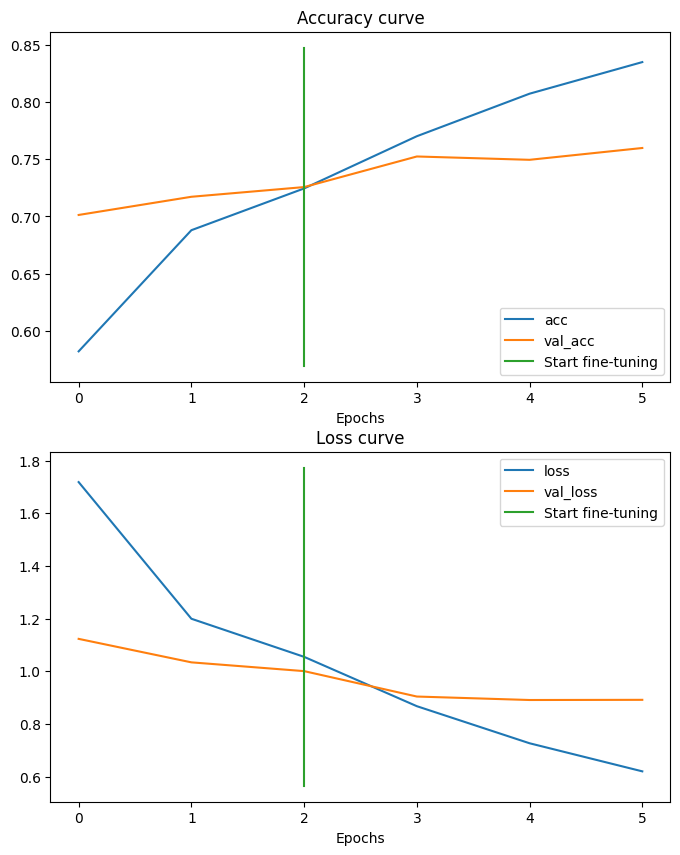

In [ ]:
compare_histories(history, history_fine_tuned, initial_epoch)

Basing on the results, I got really close to the original paper result -> **75.73%** ( original accuracy score -> **77.4%**) by improving the model with further fine-tuning for 3 more epochs.

However, I wasn't able to beat it. But luckily, I have few more options to explore.

This time I will try to tune the model's learning rate and set an **EarlyStopping callback** to improve my model.

# **Experiment 2** Fine-tune the feature-extraction model tuning the learning rate with **ReduceLROnPlateau** and using the **EarlyStopping callback**

**The learning rate** is a crucial hyperparameter that determines the step size taken during model optimization.

By tuning the learning rate, we can optimize the training process and improve model's performance.

* **ReduceLROnPlateau** : automatically adjusts the learning rate based on predefined conditions. If the validation loss stops improving, the learning rate is reduced by a specified factor, allowing the model to make smaller updates and potentially converge to a better solution.

* **EarlyStopping Callback** : is a useful to mitigate overfitting. It monitors a specified metric, such as validation loss or accuracy, and stops the training process early if the metric does not improve beyond a certain number of epochs. Early stopping helps prevent the model from continuing to learn on training data when it is no longer improving on the validation set.

## Recreate the feature-extraction model


In [ ]:
from tensorflow.keras import layers

def create_model():
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Functional API
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # set base_model to inference mode only
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  # separate activation of output layer so it outputs float32 activations for sure
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# create and compile a new version of the original model (with new weights)
recreated_model = create_model()
recreated_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

## Reload the feature-extraction model's weights from checpoint

In [ ]:
checkpoint_path = "model_checkpoint/checkpoint.ckpt"

In [ ]:
# load the saved weights
recreated_model.load_weights(checkpoint_path)

# check if the recreated model behaves the same as the original one
results_recreated_model_with_loaded_weights = recreated_model.evaluate(test_data)
results_recreated_model_with_loaded_weights

790/790 [==============================] - 71s 83ms/step - loss: 0.9989 - accuracy: 0.7285


[0.9989062547683716, 0.7284752726554871]

In [ ]:
import pandas as pd

pd.DataFrame({"feature_extraction_model": results_feature_extraction_model[1]*100, "recreated_model":results_recreated_model_with_loaded_weights[1]*100}, index=["val_accuracy"])

,feature_extraction_model,recreated_model
val_accuracy,72.847527,72.847527


Looking at the summary below, we can make sure that we're using the base version of our model with frozen layers: **Trainable params: 129,381**

In [ ]:
recreated_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Unfreeze all the layers in reloaded model

In [ ]:
for layer in recreated_model.layers:
    print(f'{layer.name} is trainable={layer.trainable} and in dtype={layer.dtype} with policy ={layer.dtype_policy}')

input_layer is trainable=True and in dtype=float32 with policy =<Policy "float32">
efficientnetb0 is trainable=False and in dtype=float32 with policy =<Policy "mixed_float16">
pooling_layer is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
dense_1 is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
softmax_float32 is trainable=True and in dtype=float32 with policy =<Policy "float32">


In case of working with big amount of data ( we have 750 images x 101 training classes = 75750 training images)
I thought that it would be a good idea to keep all of the base model's layers unfrozen.

Unfreezing all layers enables the model to make more extensive updates and fine-tune its parameters based on the specific task at hand. It allows the model to learn high-level representations that are more tailored to the dataset, potentially leading to improved performance and better generalization.

**However, it's important to note that unfreezing all the layers also increases the risk of overfitting**.

In [ ]:
for layer in recreated_model.layers[1].layers:
  layer.trainable = True

for layer in recreated_model.layers[1].layers[-10:]:
  print(f'{layer.name} is trainable={layer.trainable} and in dtype={layer.dtype} with policy ={layer.dtype_policy}')

block7a_se_squeeze is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
block7a_se_reshape is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
block7a_se_reduce is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
block7a_se_expand is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
block7a_se_excite is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
block7a_project_conv is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
block7a_project_bn is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
top_conv is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
top_bn is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
top_activation is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">


In [ ]:
for layer in recreated_model.layers:
    layer.trainable = True
    print(f'{layer.name} is trainable={layer.trainable} and in dtype={layer.dtype} with policy ={layer.dtype_policy}')

input_layer is trainable=True and in dtype=float32 with policy =<Policy "float32">
efficientnetb0 is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
pooling_layer is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
dense_1 is trainable=True and in dtype=float32 with policy =<Policy "mixed_float16">
softmax_float32 is trainable=True and in dtype=float32 with policy =<Policy "float32">


In the summary below, we can observe that the "Trainable params" value reflects the updated trainable parameters after unfreezing the layers of the baseline model:

**Trainable params: 129,381** -> **Trainable params: 1,022,613**

In [ ]:
model.summary()

Model: "Mixed_precision_feature_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 1,022,613
Non-trainable params: 3,156,339
________

## Create an **EarlyStopping Callback**

I will use the EarlyStopping Callback to stop the model after X epochs of no improvements.

In [ ]:
# stop training if model's val_loss doesn't improve for 3 more epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

## Create a **learning rate reduction callback**

I will reduce the learning rate after X epochs of no improvements with **ReduceLROnPlateau** callback.

> the ReduceLROnPlateau callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor. As training goes on and our model gets closer and closer to it's ideal performance (convergence), we want the amount it learns to be less and less.

To make sure the learning rate doesn't get too low (and potentially result in our model learning nothing),

I will set the minimum learning rate to 1e-7.

In [ ]:
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

## Recompile the model with learning rate lowered 10 times

 I will lower the model's learning rate by 10 times to reduce the risk of **overfitting**. By taking smaller steps, the model has a better chance of generalizing well to new data.

Overfitting occurs when a model becomes too specialized to the training data and performs poorly on new, unseen data.

By decreasing the learning rate, the model's updates to the weights and biases become smaller, allowing for a slower and more controlled convergence. This adjustment helps prevent the model from making drastic updates that could potentially lead to overfitting.

In [ ]:
recreated_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=["accuracy"])

## Fit the model on whole training data and validate it on 15% of test dataset

In [ ]:
# fine-tune all layers
tensorboard_callback = create_tensorboard_callback("training_logs","mixed_precision_fine_tuned_efficientnet_model_food101_early_stopping")

history_recreated_fine_tune = recreated_model.fit(train_data,
                                                        epochs=fine_tuning_epochs,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[tensorboard_callback, early_stopping, reduce_learning_rate],
                                                  initial_epoch=initial_epoch)

Saving TensorBoard log files to: training_logs/mixed_precision_fine_tuned_efficientnet_model_food101_early_stopping/20230624-065927


Epoch 4/6
2368/2368 [==============================] - 435s 157ms/step - loss: 0.8702 - accuracy: 0.7661 - val_loss: 0.7768 - val_accuracy: 0.7860 - lr: 1.0000e-04
Epoch 5/6
2368/2368 [==============================] - 376s 157ms/step - loss: 0.5365 - accuracy: 0.8511 - val_loss: 0.7766 - val_accuracy: 0.7924 - lr: 1.0000e-04
Epoch 6/6
2368/2368 [==============================] - 378s 158ms/step - loss: 0.2996 - accuracy: 0.9142 - val_loss: 0.8655 - val_accuracy: 0.7850 - lr: 1.0000e-04


## Evaluate the model

In [ ]:
# evaluate the fine-tuned model on a whole test dataset
results_fine_tuned_early_stopping = recreated_model.evaluate(test_data)
results_fine_tuned_early_stopping

790/790 [==============================] - 63s 78ms/step - loss: 0.8473 - accuracy: 0.7901


[0.8473475575447083, 0.7901386022567749]

In [ ]:
import pandas as pd

pd.DataFrame({"feature_extraction_model": results_feature_extraction_model[1]*100, "fine_tuned_model":results_fine_tuned_early_stopping[1]*100, "paper":77.4}, index=["val_accuracy"])

,feature_extraction_model,fine_tuned_model,paper
val_accuracy,72.847527,79.01386,77.4


**It seems that I finally managed to beat the original Deep Food paper results!**

However, it is essential to examine both the accuracy and loss curves as well.

If the training accuracy continues to increase while the validation accuracy plateaus decreases, it may indicate overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data. Similarly to accuracy, if the training loss curve continues to decrease while the validation loss starts to increase, it suggests overfitting, as the model fails to generalize well to new data.

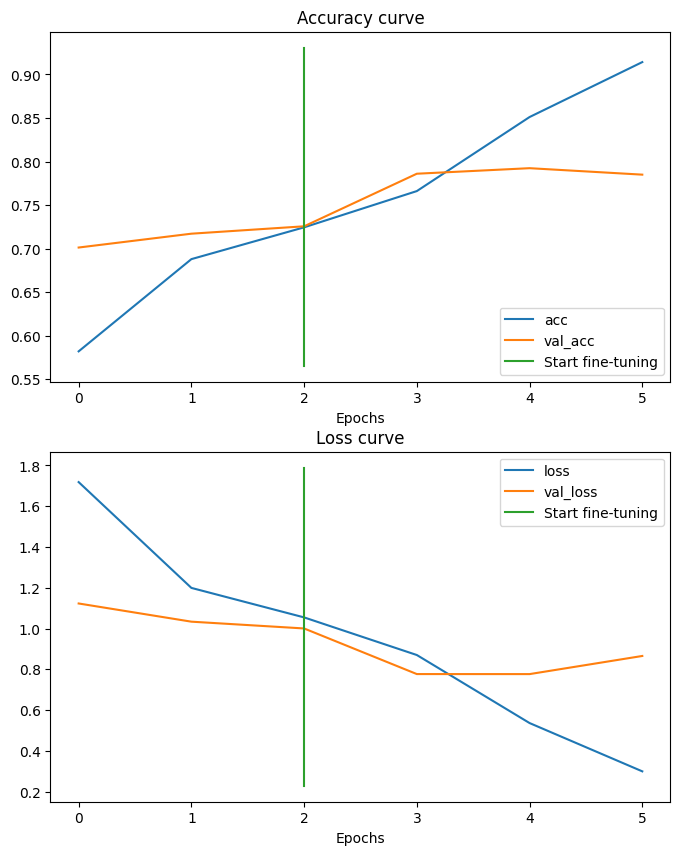

In [ ]:
compare_histories(history, history_recreated_fine_tune, initial_epoch)

In the graph above, we can observe that as the training accuracy increases, the validation accuracy starts to decrease. Similarly, the validation loss curve increases while the training loss curve continues to decrease. These observations strongly indicate that **my model is overfitting to the training data**.

This might have been caused by the fact that **I unfroze all of the layers in the baseline model**. In such cases, it may also be necessary to apply regularization techniques, such as **dropout** or **L2 regularization**, to prevent overfitting while still harnessing the full capacity of the model.



# **Test the best performing model on some random samples from test dataset**

Finally I will test the best performing version of the model on some random samples from the test dataset.

It allows us to assess how well the model generalizes to real-world examples and whether it accurately predicts the correct labels. By visually inspecting the predictions, we can identify any patterns or trends in the model's performance and gain a better understanding of its strengths and weaknesses.

This analysis helps in evaluating the model's reliability and determining if further improvements or adjustments are necessary to enhance its performance.

1/1 [==============================] - 0s 32ms/step


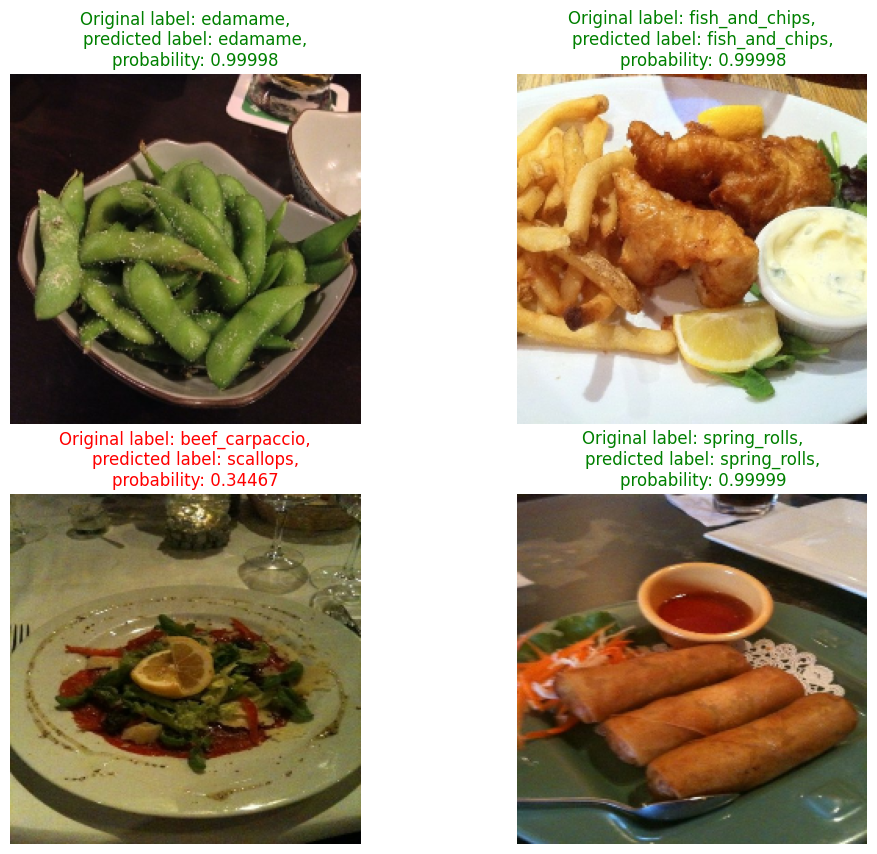

In [ ]:
import random
import numpy as np

num_of_samples = 4
plt.figure(figsize=(12,10))
# iterate through the first batch in the test dataset
for img_batch, label_batch in test_data.take(1):
  for i in range(num_of_samples):
    random_index = random.randint(0,len(img_batch)-num_of_samples)
    # random image from the first batch of test dataset
    img = img_batch[random_index]
    label = label_batch[random_index]
    label = class_names[label.numpy()]
    # make predictions
    prob = recreated_model.predict(tf.expand_dims(img, axis = 0))
    pred_label = class_names[np.argmax(prob)]
    # set the color of the title
    if label == pred_label:
      title_color = 'g'
    else:
      title_color = 'r'
    # plot the img
    plt.subplot(2,2,i+1)
    plt.imshow(img/255.)
    plt.title(f"""Original label: {label},
    predicted label: {pred_label},
    probability: {prob.max():.5f}""", c = title_color)
    plt.axis("off");

# **Compare the results using TensorBoard**

 Finally, I will compare the training results of each experiment using **TensorBoard**, providing visual insights into the model's performance.

 TensorBoard is a powerful visualization tool provided by TensorFlow that offers various functionalities for monitoring and analyzing machine learning experiments. With TensorBoard, we can visualize and compare training and validation metrics such as accuracy, loss, and learning curves, helping us understand the behavior and performance of our models over time. It also allows us to inspect the model's architecture, including the layer configurations and tensor shapes, providing insights into the model's structure.

This project : https://tensorboard.dev/experiment/rpBALgMZRmSkEf1bK47NrA/



# **Conclusion**

In conclusion, through the implementation of various techniques such as TensorFlow Datasets for data exploration, parallelizing, prefetching and batching, along with the utilization of modeling callbacks and mixed precision training, **I was able to surpass the results reported in the Deep Food paper from 2016**.

However, it is important to note that **the model exhibited signs of overfitting to the training data**. This highlights the need for further refinement and regularization techniques to improve generalization and address the overfitting issue.

Nonetheless, **the project demonstrates the effectiveness of the proposed approach in achieving superior performance** compared to prior research, setting the stage for future enhancements and advancements in the field of food image classification.